In [1]:
# 📦 Imports y carga de datos
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score



# Cargar dataset
df = pd.read_csv("../dataset/F1_Datos_limpios.csv", encoding='utf-8', low_memory=False)

In [2]:
# 🎯 Selección de features y target
features = [
    'grid','avg_grid', 'avg_position_change', 'avg_real_points', 'avg_position',
    'races', 'wins', 'dnfs','win_rate', 'dnf_rate', 'constructorId', 'driverId', 'circuitId', 'circuit_type', 'avg_gap_to_leader', 'avg_gap_to_team', 'circuit_prev_races',
    'circuit_prev_dnfs','circuit_prev_wins','circuit_prev_avg_pos','circuit_prev_avg_points','circuit_prev_dnf_rate','circuit_prev_win_rate',
    'last_n_avg_position', 'last_n_total_points', 'last_n_wins', 'last_n_dnfs', 'last_n_avg_grid', 'last_n_avg_gap_to_leader', 'last_n_avg_gap_to_team', 'last_n_avg_position_change',
    'temperature_C', 'precipitation_mm', 'wind_speed_kmh', 'humidity_pct', 'isRainy', 'driver_age', 'race_year', 'race_month', 'race_day', 'race_hour'
]
target = 'DNF'

# Filtrado y limpieza
df_original = df.copy()
df = df[features + [target]].dropna()
X = df[features]
y = df[target]


In [3]:
# 🧠 Codificación y balanceo con SMOTE
X = pd.get_dummies(X, drop_first=True)

# Balanceo de clases
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)


In [4]:
#ZeroR para comparación
from sklearn.dummy import DummyClassifier
zeroR = DummyClassifier(strategy='most_frequent')
zeroR.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

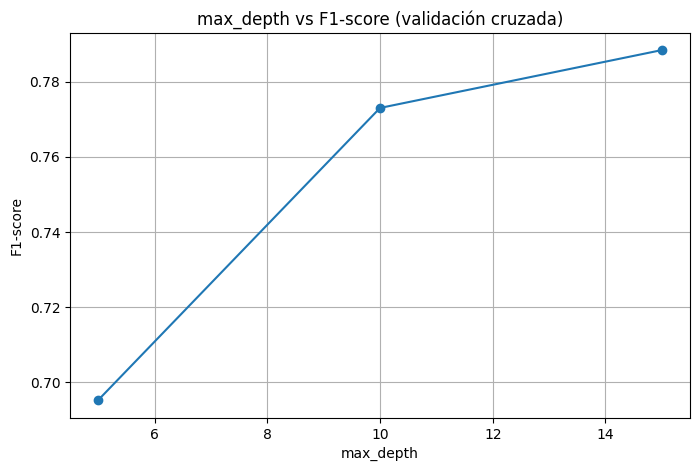

In [5]:
# 🌲 Árbol de decisión con búsqueda de hiperparámetros
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}
grid_tree = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid, cv=5, scoring='f1')
grid_tree.fit(X_train, y_train)
y_pred_tree = grid_tree.predict(X_test)

# Extraer resultados del GridSearchCV
results = pd.DataFrame(grid_tree.cv_results_)

# Filtrar para ver solo el impacto de max_depth (si querés, podés agregar más condiciones)
depth_vs_score = results.groupby('param_max_depth')['mean_test_score'].mean()

# Graficar niveles de max_depth vs F1-score
plt.figure(figsize=(8, 5))
plt.plot(depth_vs_score.index, depth_vs_score.values, marker='o')
plt.title("max_depth vs F1-score (validación cruzada)")
plt.xlabel("max_depth")
plt.ylabel("F1-score")
plt.grid(True)
plt.show()

In [6]:
# 🌳 RandomForest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [7]:
# ⚡ XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

c:\Users\salva\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:

def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre="Modelo"):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    print(f"🔍 Resultados para: {nombre}")
    print(classification_report(y_test, y_pred))
    
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {auc:.3f}")
    else:
        auc = None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

    # Curva ROC
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre}")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "modelo": nombre,
        "f1": f1_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": auc
    }


🔍 Resultados para: ZeroR (Baseline)
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1302
           1       0.00      0.00      0.00      1302

    accuracy                           0.50      2604
   macro avg       0.25      0.50      0.33      2604
weighted avg       0.25      0.50      0.33      2604

ROC-AUC: 0.500


c:\Users\salva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\salva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\salva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

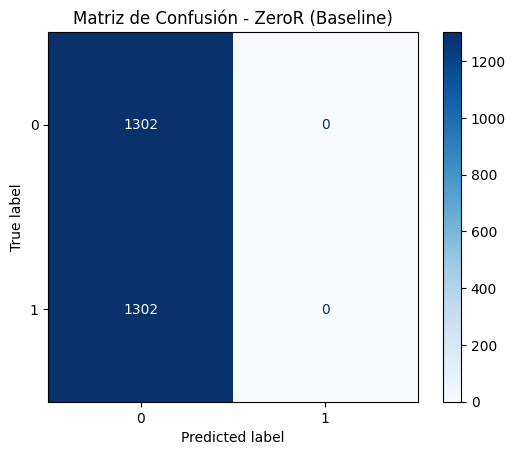

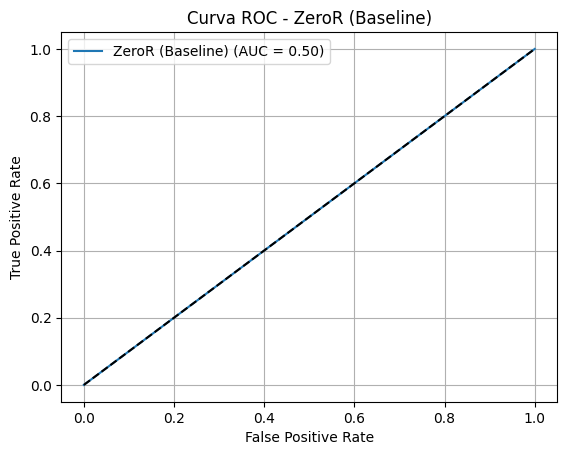

🔍 Resultados para: Decision Tree
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1302
           1       0.82      0.83      0.82      1302

    accuracy                           0.82      2604
   macro avg       0.82      0.82      0.82      2604
weighted avg       0.82      0.82      0.82      2604

ROC-AUC: 0.835


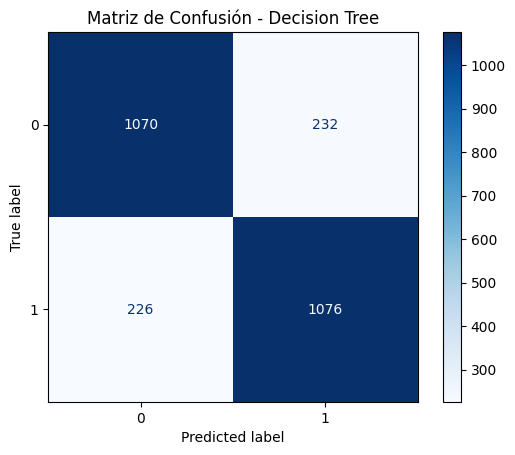

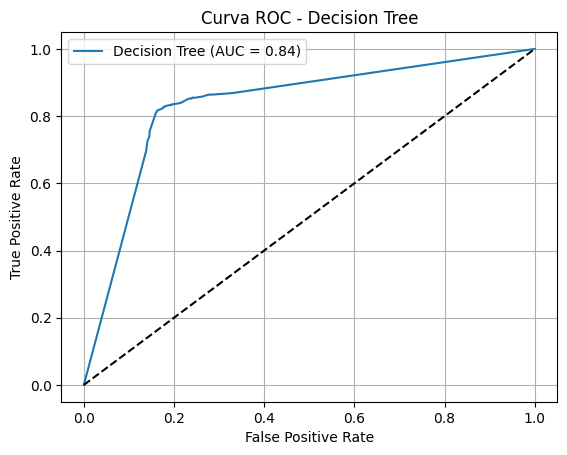

🔍 Resultados para: Random Forest
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1302
           1       0.93      0.89      0.91      1302

    accuracy                           0.91      2604
   macro avg       0.91      0.91      0.91      2604
weighted avg       0.91      0.91      0.91      2604

ROC-AUC: 0.965


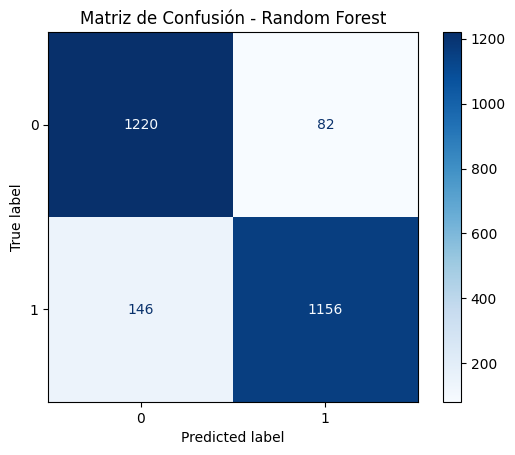

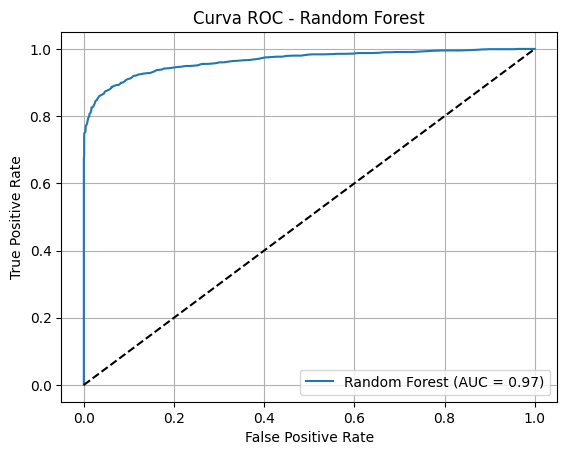

c:\Users\salva\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:54:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 Resultados para: XGBoost
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1302
           1       0.94      0.86      0.89      1302

    accuracy                           0.90      2604
   macro avg       0.90      0.90      0.90      2604
weighted avg       0.90      0.90      0.90      2604

ROC-AUC: 0.945


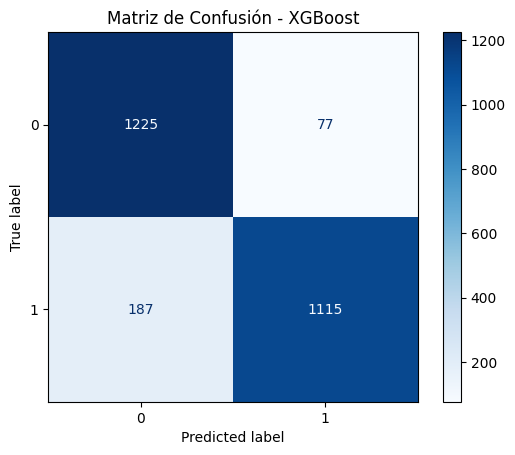

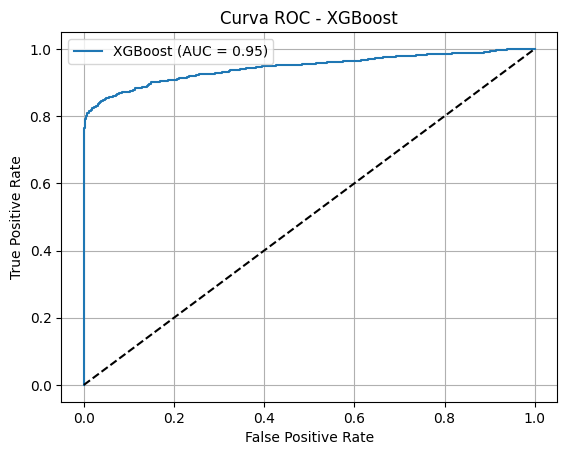

In [9]:
resultados = []

resultados.append(evaluar_modelo(zeroR, X_train, X_test, y_train, y_test, "ZeroR (Baseline)"))

resultados.append(evaluar_modelo(grid_tree, X_train, X_test, y_train, y_test, "Decision Tree"))

resultados.append(evaluar_modelo(rf, X_train, X_test, y_train, y_test, "Random Forest"))

resultados.append(evaluar_modelo(xgb, X_train, X_test, y_train, y_test, "XGBoost"))

C:\Users\salva\AppData\Local\Temp\ipykernel_12404\2938132115.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="modelo", y="f1", data=pd.DataFrame(resultados), palette="viridis")


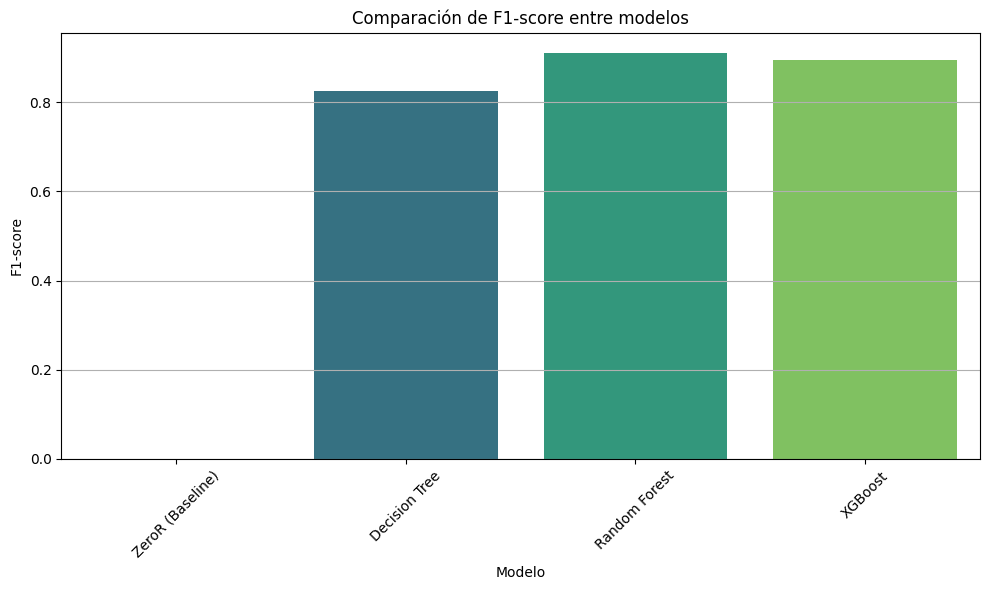

C:\Users\salva\AppData\Local\Temp\ipykernel_12404\2938132115.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="modelo", y="accuracy", data=pd.DataFrame(resultados), palette="viridis")


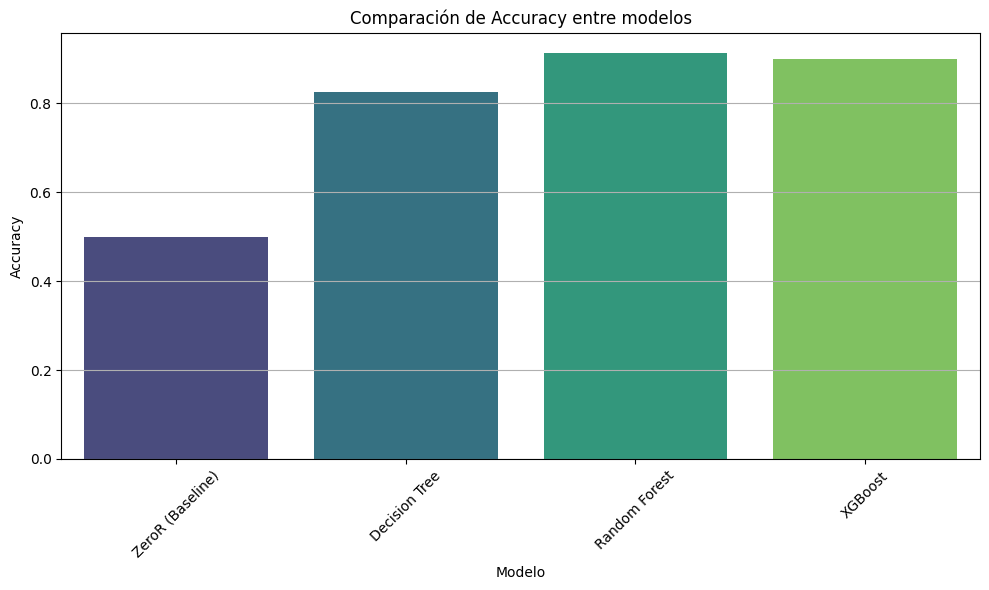

C:\Users\salva\AppData\Local\Temp\ipykernel_12404\2938132115.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="modelo", y="roc_auc", data=pd.DataFrame(resultados), palette="viridis")


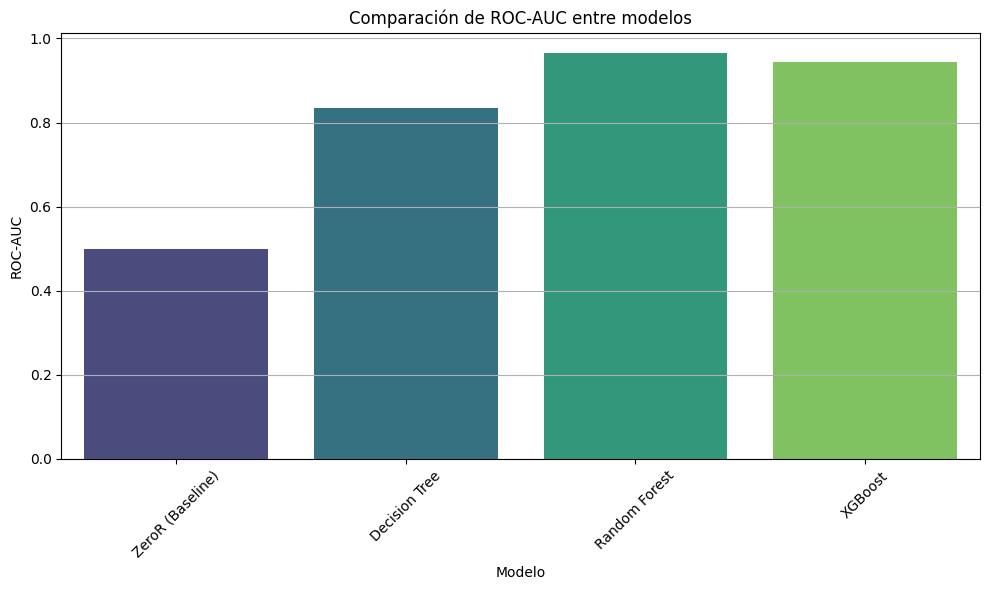

Ejemplo de columnas restantes: ['grid', 'avg_grid', 'avg_position_change', 'avg_real_points', 'avg_position', 'races', 'wins', 'dnfs', 'win_rate', 'dnf_rate', 'constructorId', 'driverId', 'circuitId', 'circuit_type', 'avg_gap_to_leader', 'avg_gap_to_team', 'circuit_prev_races', 'circuit_prev_dnfs', 'circuit_prev_wins', 'circuit_prev_avg_pos', 'circuit_prev_avg_points', 'circuit_prev_dnf_rate', 'circuit_prev_win_rate', 'last_n_avg_position', 'last_n_total_points', 'last_n_wins', 'last_n_dnfs', 'last_n_avg_grid', 'last_n_avg_gap_to_leader', 'last_n_avg_gap_to_team', 'last_n_avg_position_change', 'temperature_C', 'precipitation_mm', 'wind_speed_kmh', 'humidity_pct', 'isRainy', 'driver_age', 'race_year', 'race_month', 'race_day', 'race_hour', 'DNF']


In [10]:
pd.DataFrame(resultados).set_index("modelo")
#graficar los resultados, de modo que se pueda ver la diferencia de f1, accuracy y roc_auc entre los mismos, tener en cuenta que es muy sutil (0.04 o 0.05) y que puede ser necesario hacer zoom en el eje y
plt.figure(figsize=(10, 6))
sns.barplot(x="modelo", y="f1", data=pd.DataFrame(resultados), palette="viridis")
plt.title("Comparación de F1-score entre modelos")
plt.ylabel("F1-score")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="modelo", y="accuracy", data=pd.DataFrame(resultados), palette="viridis")
plt.title("Comparación de Accuracy entre modelos")
plt.ylabel("Accuracy")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="modelo", y="roc_auc", data=pd.DataFrame(resultados), palette="viridis")
plt.title("Comparación de ROC-AUC entre modelos")
plt.ylabel("ROC-AUC")
plt.xlabel("Modelo")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("Ejemplo de columnas restantes:", df.columns.tolist())

C:\Users\salva\AppData\Local\Temp\ipykernel_12404\3111352866.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df_tree, palette='viridis')


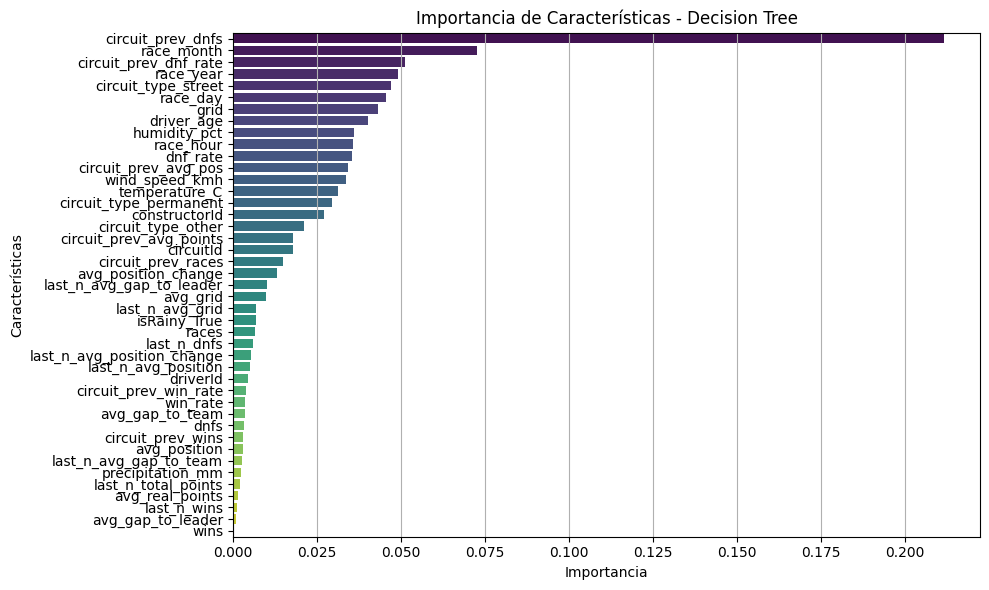

C:\Users\salva\AppData\Local\Temp\ipykernel_12404\3111352866.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df_rf, palette='viridis')


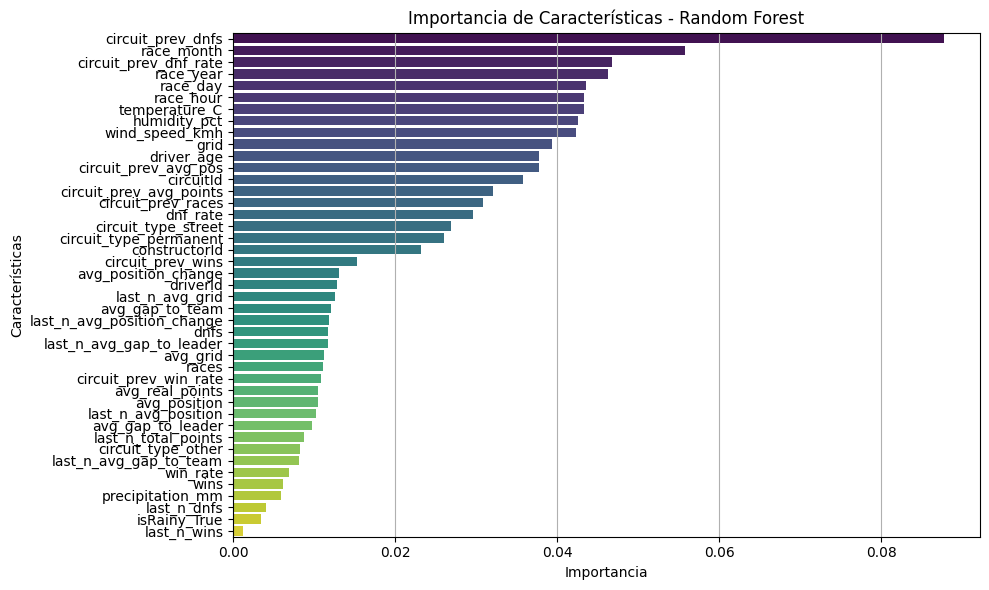

C:\Users\salva\AppData\Local\Temp\ipykernel_12404\3111352866.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df_xgb, palette='viridis')


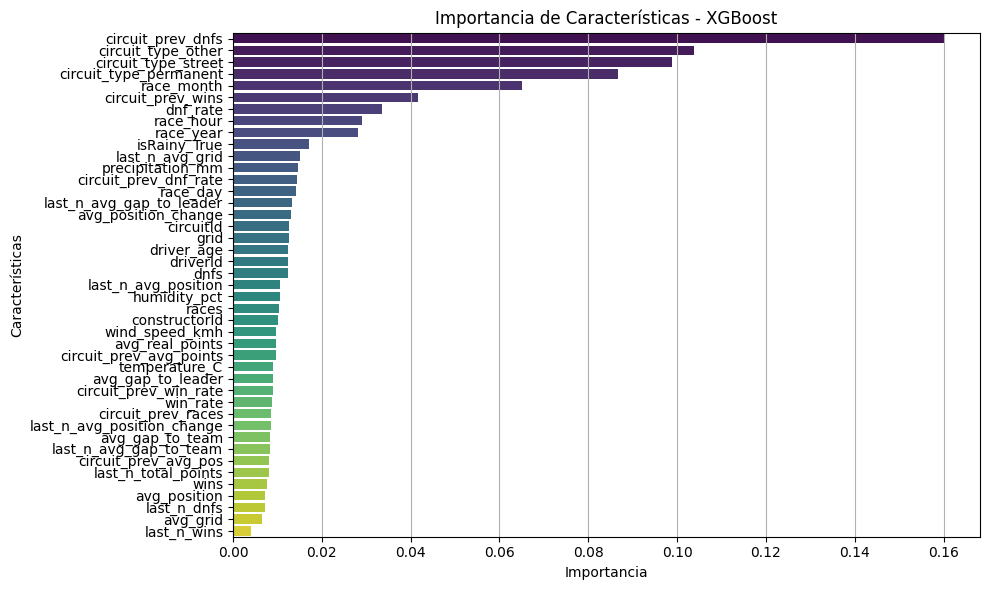

In [11]:
#variables mas importantes de cada modelo
# Importancia de características del decision tree
importances_tree = grid_tree.best_estimator_.feature_importances_
feature_names_tree = X_train.columns
importance_df_tree = pd.DataFrame({'feature': feature_names_tree, 'importance': importances_tree})
importance_df_tree = importance_df_tree.sort_values(by='importance', ascending=False)
# Graficar importancia de características del Decision Tree
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df_tree, palette='viridis')
plt.title("Importancia de Características - Decision Tree")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(axis='x')
plt.tight_layout()
plt.show()
# Importancia de características del Random Forest
importances_rf = rf.feature_importances_
feature_names_rf = X_train.columns
importance_df_rf = pd.DataFrame({'feature': feature_names_rf, 'importance': importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='importance', ascending=False)
# Graficar importancia de características del Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df_rf, palette='viridis')
plt.title("Importancia de Características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(axis='x')
plt.tight_layout()
plt.show()
# Importancia de características del XGBoost
importances_xgb = xgb.feature_importances_
feature_names_xgb = X_train.columns
importance_df_xgb = pd.DataFrame({'feature': feature_names_xgb, 'importance': importances_xgb})
importance_df_xgb = importance_df_xgb.sort_values(by='importance', ascending=False)
# Graficar importancia de características del XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df_xgb, palette='viridis')
plt.title("Importancia de Características - XGBoost")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [12]:
def predecir_dnf(modelo, df_original, filtro, features):
    # Filtramos las filas específicas
    df_filtrado = df_original.query(filtro).copy()

    if df_filtrado.empty:
        print("⚠️ No se encontraron filas con ese filtro.")
        return

    X_filtrado = df_filtrado[features]
    # Aplicar la misma codificación one-hot que en el entrenamiento
    X_filtrado_encoded = pd.get_dummies(X_filtrado, drop_first=True)
    # Alinear columnas con las usadas en el entrenamiento
    X_filtrado_encoded = X_filtrado_encoded.reindex(columns=X.columns, fill_value=0)

    predicciones = modelo.predict(X_filtrado_encoded)
    probabilidades = modelo.predict_proba(X_filtrado_encoded)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Mostramos resultados
    df_filtrado_resultado = df_filtrado.copy()
    df_filtrado_resultado['prediccion_DNF'] = predicciones
    if probabilidades is not None:
        df_filtrado_resultado['probabilidad_DNF'] = probabilidades

    return df_filtrado_resultado

🔎 Predicciones de DNF para: Decision Tree


,raceId,year,circuitRef,driverRef,constructorRef,DNF,prediccion_DNF,probabilidad_DNF
1753,85,2005,monza,montoya,mclaren,0,1,1.0
1754,85,2005,monza,alonso,renault,0,0,0.0
1755,85,2005,monza,fisichella,renault,0,0,0.0
1756,85,2005,monza,raikkonen,mclaren,0,0,0.0
1757,85,2005,monza,trulli,toyota,0,0,0.0
1758,85,2005,monza,ralf_schumacher,toyota,0,0,0.0
1759,85,2005,monza,pizzonia,williams,0,0,0.0
1760,85,2005,monza,button,bar,0,0,0.0
1761,85,2005,monza,massa,sauber,0,0,0.0
1762,85,2005,monza,michael_schumacher,ferrari,0,1,1.0


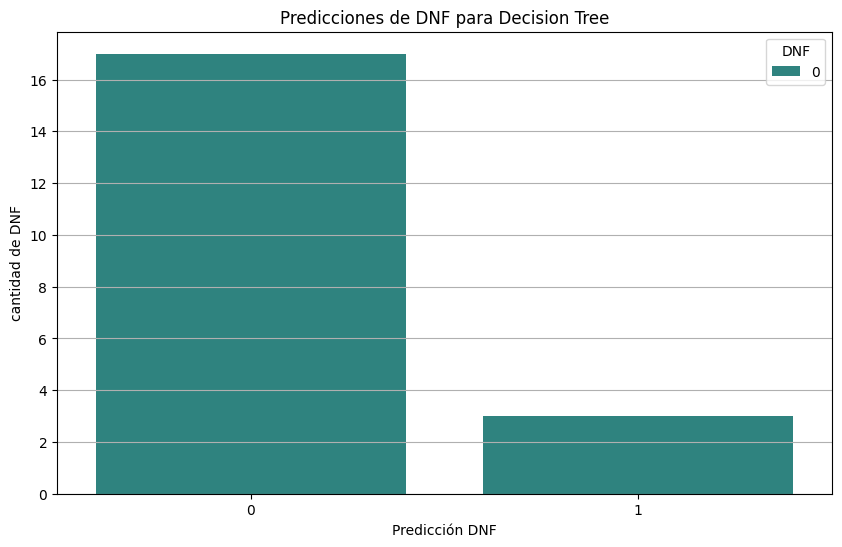

🔎 Predicciones de DNF para: Random Forest


,raceId,year,circuitRef,driverRef,constructorRef,DNF,prediccion_DNF,probabilidad_DNF
1753,85,2005,monza,montoya,mclaren,0,0,0.270
1754,85,2005,monza,alonso,renault,0,0,0.185
1755,85,2005,monza,fisichella,renault,0,0,0.110
1756,85,2005,monza,raikkonen,mclaren,0,0,0.300
1757,85,2005,monza,trulli,toyota,0,0,0.170
1758,85,2005,monza,ralf_schumacher,toyota,0,0,0.105
1759,85,2005,monza,pizzonia,williams,0,0,0.360
1760,85,2005,monza,button,bar,0,0,0.125
1761,85,2005,monza,massa,sauber,0,0,0.135
1762,85,2005,monza,michael_schumacher,ferrari,0,0,0.170


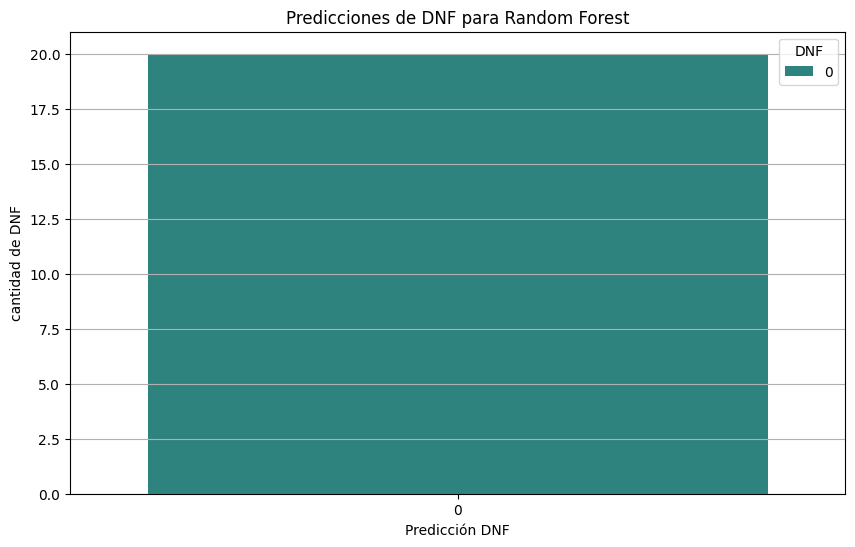

🔎 Predicciones de DNF para: XGBoost


,raceId,year,circuitRef,driverRef,constructorRef,DNF,prediccion_DNF,probabilidad_DNF
1753,85,2005,monza,montoya,mclaren,0,0,0.255638
1754,85,2005,monza,alonso,renault,0,0,0.040684
1755,85,2005,monza,fisichella,renault,0,0,0.004259
1756,85,2005,monza,raikkonen,mclaren,0,0,0.035057
1757,85,2005,monza,trulli,toyota,0,0,0.010066
1758,85,2005,monza,ralf_schumacher,toyota,0,0,0.016755
1759,85,2005,monza,pizzonia,williams,0,0,0.135554
1760,85,2005,monza,button,bar,0,0,0.016880
1761,85,2005,monza,massa,sauber,0,0,0.039016
1762,85,2005,monza,michael_schumacher,ferrari,0,0,0.108536


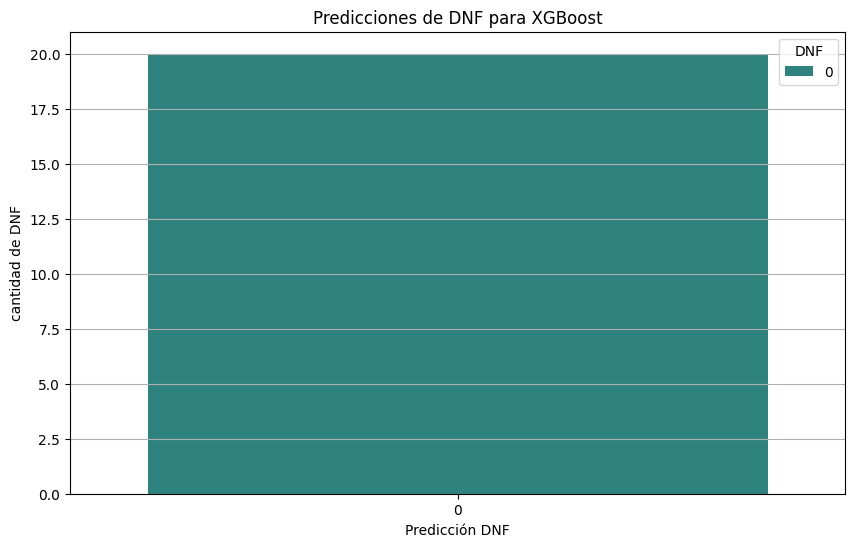

In [13]:
filtro = "raceId == 85"

# Para el árbol de decisión
df_decision_tree = predecir_dnf(grid_tree.best_estimator_, df_original, filtro, features)
print(f"🔎 Predicciones de DNF para: Decision Tree")
display(df_decision_tree[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'DNF', 'prediccion_DNF', 'probabilidad_DNF'] if df_decision_tree['probabilidad_DNF'] is not None else ['raceId', 'driverId', 'constructorId', 'prediccion_DNF']])
#graficar prediccion_DNF y DNF para Decision Tree
plt.figure(figsize=(10, 6))
sns.countplot(data=df_decision_tree, x='prediccion_DNF', hue='DNF', palette='viridis')
plt.title("Predicciones de DNF para Decision Tree")
plt.xlabel("Predicción DNF")
plt.ylabel("cantidad de DNF")
plt.grid(axis='y')
plt.show()

# Para probar con el modelo de Random Forest
df_random_forest = predecir_dnf(rf, df_original, filtro, features)
print(f"🔎 Predicciones de DNF para: Random Forest")
display(df_random_forest[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'DNF', 'prediccion_DNF', 'probabilidad_DNF'] if df_random_forest['probabilidad_DNF'] is not None else ['raceId', 'driverId', 'constructorId', 'prediccion_DNF']])
#graficar prediccion_DNF y DNF para random forest
plt.figure(figsize=(10, 6))
sns.countplot(data=df_random_forest, x='prediccion_DNF', hue='DNF', palette='viridis')
plt.title("Predicciones de DNF para Random Forest")
plt.xlabel("Predicción DNF")
plt.ylabel("cantidad de DNF")
plt.grid(axis='y')
plt.show()

# Para XGBoost
df_xgboost = predecir_dnf(xgb, df_original, filtro, features)
print(f"🔎 Predicciones de DNF para: XGBoost")
display(df_xgboost[['raceId','year','circuitRef', 'driverRef', 'constructorRef', 'DNF', 'prediccion_DNF', 'probabilidad_DNF'] if df_xgboost['probabilidad_DNF'] is not None else ['raceId', 'driverId', 'constructorId', 'prediccion_DNF']])
#graficar prediccion_DNF y DNF para xgboost
plt.figure(figsize=(10, 6))
sns.countplot(data=df_xgboost, x='prediccion_DNF', hue='DNF', palette='viridis')
plt.title("Predicciones de DNF para XGBoost")
plt.xlabel("Predicción DNF")
plt.ylabel("cantidad de DNF")
plt.grid(axis='y')
plt.show()